## Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [1]:
!nvidia-smi

Sun Nov 26 06:46:52 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant.

In [2]:
import os
HOME = os.getcwd()
print(HOME)

/content


## Install Grounding DINO & additional dependencies

In addition to Grounding DINO, we will install some additional packages:
- `roboflow` - To download and send datasets to cloud.
- `dataclasses-json` - To make it easier to process COCO JSON and load data from disk.
- `onemetric` - To compare the results of manual labeling with those obtained with Grounding DINO.

In [3]:
%cd {HOME}
!git clone https://github.com/IDEA-Research/GroundingDINO.git
%cd {HOME}/GroundingDINO

# we use latest Grounding DINO model API that is not official yet
!git checkout feature/more_compact_inference_api

!pip install -q -e .
!pip install -q roboflow dataclasses-json onemetric

/content
Cloning into 'GroundingDINO'...
remote: Enumerating objects: 415, done.
remote: Counting objects: 100% (177/177), done.
remote: Compressing objects: 100% (57/57), done.
remote: Total 415 (delta 136), reused 123 (delta 120), pack-reused 238
Receiving objects: 100% (415/415), 12.85 MiB | 33.23 MiB/s, done.
Resolving deltas: 100% (214/214), done.
/content/GroundingDINO
Branch 'feature/more_compact_inference_api' set up to track remote branch 'feature/more_compact_inference_api' from 'origin'.
Switched to a new branch 'feature/more_compact_inference_api'
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.7/254.7 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.3/63.3 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.8 MB/s et

**NOTE:** Before we begin, let's still log the version of all the key libraries we will use.

In [4]:
import torch
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)

import roboflow
import supervision

print(
    "roboflow:", roboflow.__version__,
    "; supervision:", supervision.__version__
)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0
torch:  2.1 ; cuda:  cu118
roboflow: 1.1.9 ; supervision: 0.4.0


**NOTE:** To run the Grounding DINO model we will need two things: a configuration file and a weights file. The first one is part of the repository we just cloned. The second one we need to download.

In [5]:
# confirm that configuration file exist

import os

CONFIG_PATH = os.path.join(HOME, "GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py")
print(CONFIG_PATH, "; exist:", os.path.isfile(CONFIG_PATH))

/content/GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py ; exist: True


In [6]:
# download weights file

%cd {HOME}
!mkdir {HOME}/weights
%cd {HOME}/weights

!wget -q https://github.com/IDEA-Research/GroundingDINO/releases/download/v0.1.0-alpha/groundingdino_swint_ogc.pth

/content
/content/weights


In [7]:
# confirm that weights file exist

import os

WEIGHTS_PATH = os.path.join(HOME, "weights", "groundingdino_swint_ogc.pth")
print(WEIGHTS_PATH, "; exist:", os.path.isfile(WEIGHTS_PATH))

/content/weights/groundingdino_swint_ogc.pth ; exist: True


### Mounting Google Drive for image dataset

---
1. source_folder - Stores original image dataset
2. target_folder - a new folder data to store copied images of source_folder with valid files extensions.

In [9]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [10]:
%cd {HOME}
!mkdir {HOME}/data
%cd {HOME}/data

import shutil

source_folder = '/content/gdrive/MyDrive/YoloVehicleTrack/Inventory pictures'
target_folder = '/content/data'

# Copy images from Google Drive to Colab
for filename in os.listdir(source_folder):
    if filename.endswith(('.jpg', '.png')):
        source_path = os.path.join(source_folder, filename)
        target_path = os.path.join(target_folder, filename)
        shutil.copy(source_path, target_path)

/content
/content/data


## Load model

In [11]:
%cd {HOME}/GroundingDINO

from groundingdino.util.inference import Model

model = Model(model_config_path=CONFIG_PATH, model_checkpoint_path=WEIGHTS_PATH)

/content/GroundingDINO


torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)


final text_encoder_type: bert-base-uncased


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

## Model Prompt Engineering Results

Let's compare the prediction results we can get by running the Grounding DINO model in different modes, and what effect feature engineering has on the quality of the obtained results

In [12]:
SOURCE_IMAGE_PATH = f"{HOME}/data/20231121_121427.jpg" # Single image Inference
CLASSES = ['headlamp', 'men underwear', 'book', 'candy', 'paper', 'box', 'bottle']
BOX_TRESHOLD = 0.30
TEXT_TRESHOLD = 0.20

### Enhanced Classes Inference Mode
---
**NOTE:** You pass list of classes as a argument. Those classes are enhenced using prompt engineering to ensure better result. Phrases returned by the model during prediction are treated as categories. For this reason, BoxAnnotator produces paint boxes with the same associated categories with the same color.

In [13]:
from typing import List

def enhance_class_name(class_names: List[str]) -> List[str]:
    return [
        f"all {class_name}s"
        for class_name
        in class_names
    ]

##**Single image Inference**

The `device` argument is deprecated and will be removed in v5 of Transformers.
torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
None of the inputs have requires_grad=True. Gradients will be None


['box 0.53', 'box 0.50', 'box 0.48', 'box 0.43', 'box 0.41', 'box 0.44', 'headlamp 0.34', 'box 0.32', 'box 0.37', 'bottle 0.36', 'box 0.35', 'box 0.38', 'paper 0.32', 'box 0.44', 'bottle 0.39', 'bottle 0.34', 'paper 0.36', 'paper 0.36', 'headlamp 0.32', 'headlamp 0.40', 'bottle 0.31']


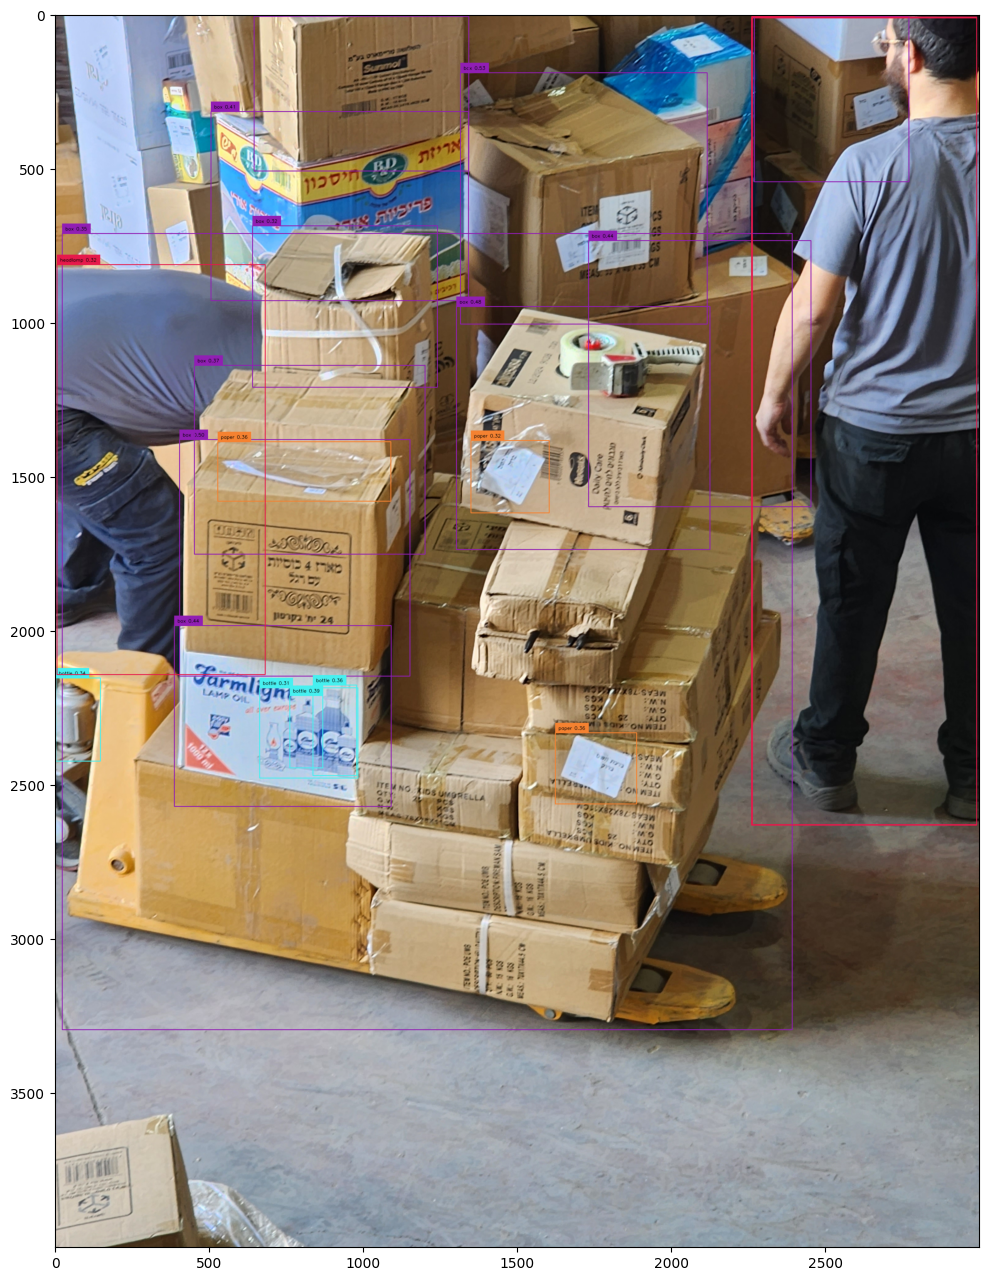

headlamp: 3
men underwear: 0
book: 0
candy: 0
paper: 3
box: 11
bottle: 4


In [14]:
import cv2

import supervision as sv

image = cv2.imread(SOURCE_IMAGE_PATH)

detections = model.predict_with_classes(
    image=image,
    classes=enhance_class_name(class_names=CLASSES),
    box_threshold=BOX_TRESHOLD,
    text_threshold=TEXT_TRESHOLD
)
# print(detections)

# Assuming detections is the Detections object
class_ids = detections.class_id
# Convert None to 0 if needed
class_ids = [0 if cid is None else cid for cid in class_ids] # Replace None with 0 in class_id array
# print(class_ids)
detections.class_id = class_ids

box_annotator = sv.BoxAnnotator()
labels = [
    f"{CLASSES[class_id]} {confidence:0.2f}"
    for _, confidence, class_id, _
    in detections]
annotated_frame = box_annotator.annotate(scene=image.copy(), detections=detections, labels=labels)
print(labels)
%matplotlib inline
sv.plot_image(annotated_frame, (16, 16))


# Initialize a dictionary to store counts for each class
class_counts = {class_name: 0 for class_name in CLASSES}

# Count occurrences of each class
for class_id in class_ids:
    class_name = CLASSES[class_id]
    class_counts[class_name] += 1

# Print the results
for class_name, count in class_counts.items():
    print(f"{class_name}: {count}")

##**Multiple image Inference**

In [ ]:
import os
import cv2
import supervision as sv

# Assuming you have your model and constants defined before this

# Define the folder containing images
IMAGE_FOLDER = '/content/data'
CLASSES = ['headlamp', 'men underwear', 'book', 'candy', 'paper', 'box', 'bottle']
BOX_TRESHOLD = 0.30
TEXT_TRESHOLD = 0.20

# Loop through all images in the folder
for filename in os.listdir(IMAGE_FOLDER):
    if filename.endswith(('.jpg', '.png')):
        # Construct the full path to the image
        image_path = os.path.join(IMAGE_FOLDER, filename)

        # Read the image
        image = cv2.imread(image_path)

        # Perform detections
        detections = model.predict_with_classes(
            image=image,
            classes=enhance_class_name(class_names=CLASSES),
            box_threshold=BOX_TRESHOLD,
            text_threshold=TEXT_TRESHOLD
        )

        # Update class_ids and annotate the image
        class_ids = detections.class_id
        class_ids = [0 if cid is None else cid for cid in class_ids]
        detections.class_id = class_ids

        box_annotator = sv.BoxAnnotator()
        labels = [f"{CLASSES[class_id]} {confidence:0.2f}" for _, confidence, class_id, _ in detections]
        annotated_frame = box_annotator.annotate(scene=image.copy(), detections=detections, labels=labels)

        # Display annotated image
        sv.plot_image(annotated_frame, (16, 16))

        # Initialize a dictionary to store counts for each class
        class_counts = {class_name: 0 for class_name in CLASSES}

        # Count occurrences of each class
        for class_id in class_ids:
            class_name = CLASSES[class_id]
            class_counts[class_name] += 1

        # Print the results
        print(f"Results for {filename}:")
        for class_name, count in class_counts.items():
            print(f"{class_name}: {count}")
        print("\n" + "=" * 30 + "\n")